## Install the requirements

In [12]:
import np
!wget --show-progress 'https://d3js.org/d3.v3.js'
!pip install --upgrade jinja2==3.0.3
from IPython.core.display import HTML
HTML('<script src="d3.v3.js"></script>')

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [14]:
!pip install lxml
!pip install python-igraph
!pip install cairocffi

## If necessary, restart kernel now

In [15]:
import os
#download graphframes package
!wget -q --show-progress http://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark2.4-s_2.12/:graphframes-0.8.1-spark2.4-s_2.12.jar -P /home/jovyan/
#tell to load graphframes and dependencies to the spark cluster for use
os.environ["PYSPARK_SUBMIT_ARGS"] = '--repositories "http://repos.spark-packages.org" --packages graphframes:graphframes:0.8.1-spark2.4-s_2.12 --jars /home/jovyan/.ivy2/jars/com.typesafe.scala-logging_scala-logging-api_2.12-2.1.2.jar,/home/jovyan/.ivy2/jars/org.scala-lang_scala-reflect-2.12.0.jar,/home/jovyan/.ivy2/jars/com.typesafe.scala-logging_scala-logging-slf4j_2.12-2.1.2.jar,/home/jovyan/.ivy2/jars/org.slf4j_slf4j-api-1.7.7.jar,/home/jovyan/.ivy2/jars/graphframes_graphframes-0.8.1-spark2.4-s_2.12.jar pyspark-shell'

In [4]:
import pyspark
from pyspark.sql import *
try:
    sc = pyspark.SparkContext('local[*]',environment = {})
except:
    sc = sc
#create sqlcontext on the spark, enables the use of the SQL queries below
sqlContext = SQLContext(sc)
sqlContext = pyspark.sql.SparkSession(sc)
sc.setLogLevel("ERROR")


/Users/macbook/miniconda3/lib/python3.12/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Do not mind the warning about deprecation 

### Below is a tiny example on how to create a graph

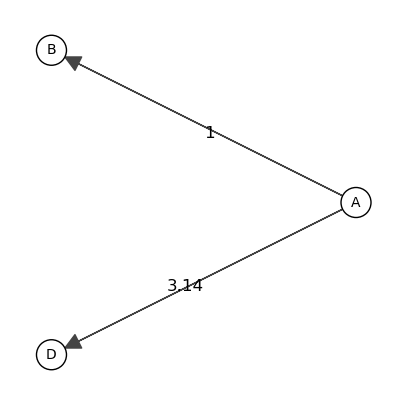

In [17]:
import igraph as ig
import matplotlib.pyplot as plt
# Create a Vertex DataFrame with unique ID column "id"
#edges=([(from0,to0),(from1,to1),(to1,from0)]), etc... first is zero, rest is done in g.vs["name"] order
edges=([(0, 1), (0, 2)])
g = ig.Graph(3,edges,directed=True)
g.vs["name"] = ["A", "B", "D"]
g.es["weights"]=[1,3.14]
display(g)

fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g,target=ax,layout="circle",vertex_size=30,vertex_color="white",vertex_frame_width=1.0, vertex_frame_color="black",vertex_label=g.vs["name"],vertex_label_size=10.0,edge_width=1,edge_arrow_size=15, edge_label=g.es["weights"])
plt.show()


### Task 4.2.1 (3 p)

Modify the code below using the above example to form the graph that is shown in the Mining Massive Datasets book in figure 5.1 (figure below). Additionally, give random numbers to the edges (add random numbers in g.es["weights"]).  

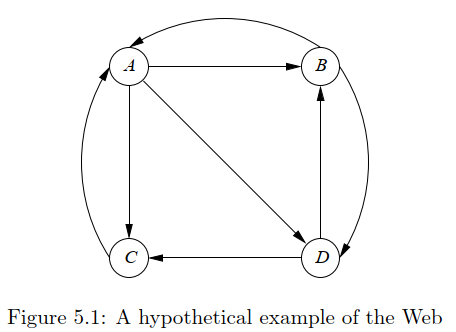

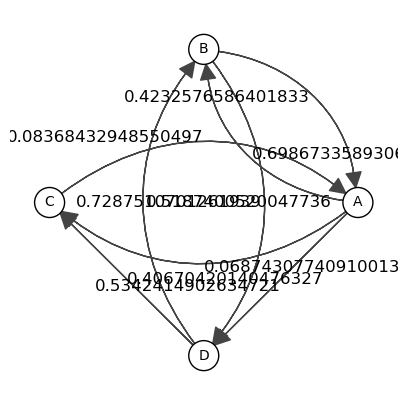

In [18]:
# Create a GraphFrame
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

edges = [(0, 1), (0, 2), (0, 3),(1, 0), (1, 3),(2, 0),(3, 1),(3, 2)]

g = ig.Graph(4,edges,directed=True)
g.vs["name"] = ["A", "B", "C", "D"]
g.es["weights"]=np.random.rand(len(edges))  #Note: length of the "g.es" should be the same as length of "edges"
display(g)

fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g,target=ax,layout="circle",vertex_size=30,vertex_color="white",vertex_frame_width=1.0, vertex_frame_color="black",vertex_label=g.vs["name"],vertex_label_size=10.0,edge_width=1,edge_arrow_size=15, edge_label=g.es["weights"])
plt.show()


Below is the code for applying the pagerank algorithm to the graph. What the pagerank algorithm computes?

Calculate PageRank for the matrix in figure 5.3 of the course book change damping from 0.85, to 0.5 and 0.9. Explain what the 'damping' parameter does? How did the pageRank change in this case?

In [19]:
# Run PageRank algorithm, and show results.
results=ig.Graph.pagerank(g, implementation='power', directed=True, damping=0.85)
print(results)

[0.32456140350877194, 0.22514619883040934, 0.22514619883040934, 0.22514619883040934]


### Answers 4.2.1

**What the pagerank algorithm computes?**

PageRank computes the probability that a random surfer will be on each node, so pages with higher values  are visited more often and therefore considered more important

<img src="im2.png" alt="image" width="300"/>

Now rewriting graph's data and running pagerank with damping = 0.85, 0.50, 0.90

In [20]:
import igraph as ig, numpy as np

edges = [
    (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 3),
    (3, 1), (3, 2)
]

g53 = ig.Graph(4, edges, directed=True)
g53.vs['name'] = ["A", "B", "C", "D"]

for d in [0.85, 0.50, 0.90]:
    pr = g53.pagerank(implementation='power', directed=True, damping=d)
    print(f"damping = {d:>4}: {pr}")

damping = 0.85: [0.20618556701030927, 0.2646048109965636, 0.2646048109965636, 0.2646048109965636]
damping =  0.5: [0.2222222222222222, 0.25925925925925924, 0.25925925925925924, 0.25925925925925924]
damping =  0.9: [0.20408163265306117, 0.26530612244897955, 0.2653061224489796, 0.2653061224489796]


**Explain what the ‘damping’ parameter does?**

The damping parameter manages how likely the random surfer is to go by an existing out-link instead of jumping to a random node; lower values mean more teleporting, and in this case the effect of the link structure is lower. It also helps to avoid dead ends and spider traps. Higher values go vice versa.

**How did the PageRank change in this case?**

With low damping (0.5), the PageRank was more equal because of higher teleporting, and with higher damping (0.9) we got bigger spread out since the real structure played a bigger role.

### Task 4.2.2 (4 p)

In the code below, the Moodle zip-package data is used. 
Describe the data, what information do the files contain (you can have a look at the readme-Ego.txt file available on the web page https://snap.stanford.edu/data/egonets-Facebook.html )?
We do not use the feature files in this exercise.

What is the degree of a node?   

Is the PageRank algorithm any better than just the degree of a node to find the most important vertices of the network? Give some examples which user ids you think are important by visual inspection (see image), and in pagerank or degree. (For some analyses a vertex can be important if it connects network parts that would be isolated without the connecting vertex.)

66
540
[0.004487921923939519, 0.005749921003888703, 0.003704803663141995, 0.004623449286823166, 0.0016720765027717652, 0.0008053691275180309, 0.00627773212553589, 0.004812485594526602, 0.005781745862581488, 0.0046782169404037625, 0.00536745386034648, 0.0057876505832815195, 0.0035922322419068746, 0.004678216940402427, 0.004739284660697229, 0.006779467213841825, 0.007340304800119276, 0.004678216940400981, 0.0033175083812565917, 0.007474031543113971, 0.006779467213843215, 0.006689835111174023, 0.006483197761824867, 0.006833417484908045, 0.005835715018580415, 0.0038236574999233213, 0.004971971129013626, 0.006911697771533003, 0.0058357150185773836, 0.008056330923175151, 0.0008053691275180309, 0.005974057177077775, 0.005367453860345793, 0.006363281256286476, 0.004820719731696256, 0.009056580002896839, 0.0033185185404160564, 0.004881685553549504, 0.005727614637276211, 0.0035910080943332076, 0.006645306340729747, 0.0039607960400849795, 0.0008053691275180309, 0.003077680787757083, 0.00125004181

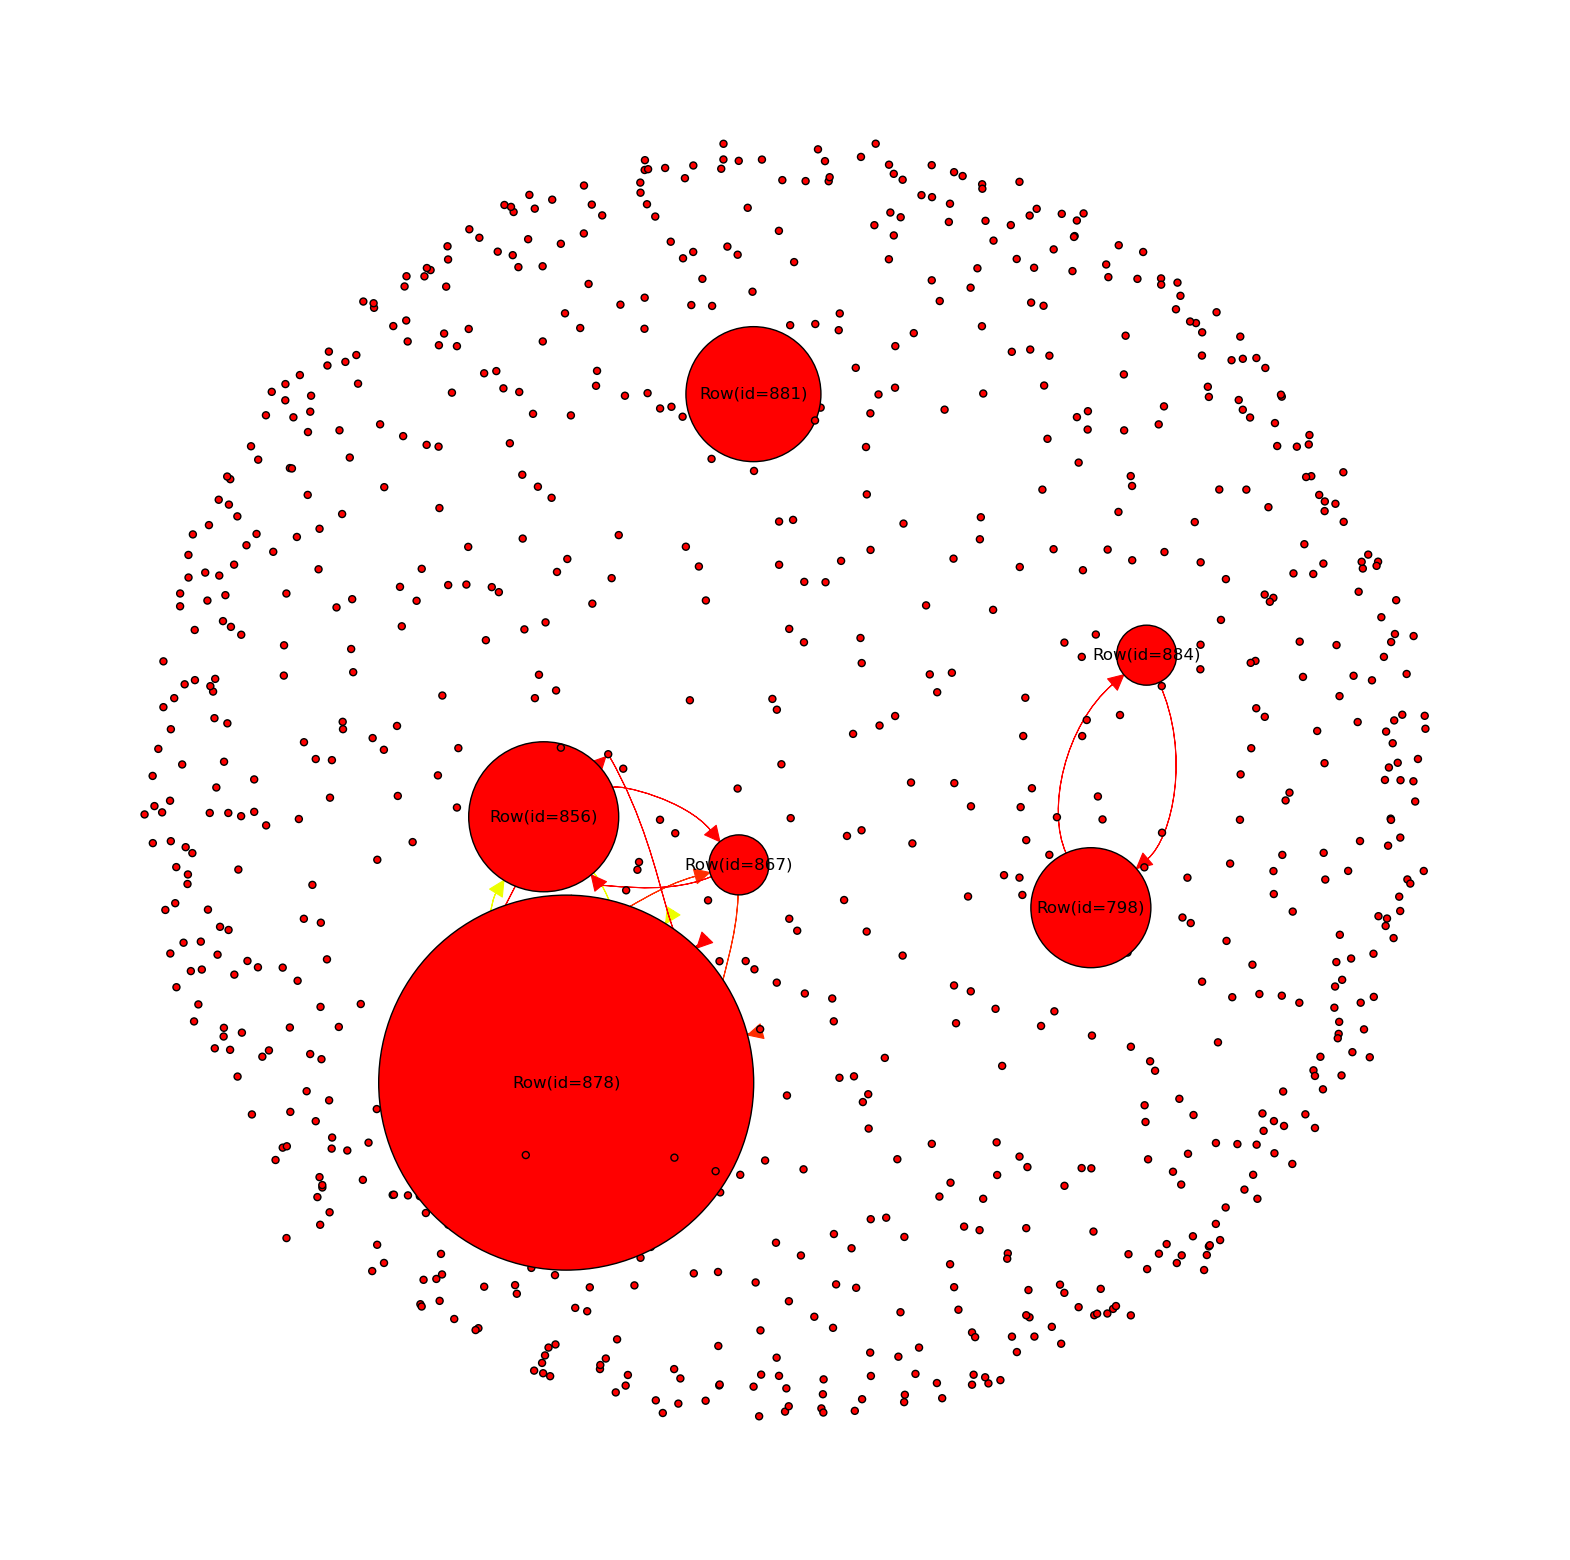

In [25]:
import igraph as ig
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
import numpy as np
#read graph edges(or arcs, lines) (multiple edges per vertex can exist)
lines = sc.textFile("698.edges")
edges = lines.map(lambda l: l.split(" ")). \
            map(lambda p: Row( src=int(p[0]), dst=int(p[1])) )
edges = sqlContext.createDataFrame(edges)

#read graph vertices(or nodes, points) (these are unique)
lines = sc.textFile("698.feat")
vertices = lines.map(lambda l: l.split(" ")). \
            map(lambda p: Row(id=int(p[0]), name="userid_"+p[0]) )
vertices = sqlContext.createDataFrame(vertices)    

idx_array = vertices.select("id").rdd.flatMap(lambda x: x).collect()
#print(idx_array)

#edges.show()
#vertices.show()
len_vertices=vertices.count()
print(len_vertices)
print(edges.count())


list_edges=[]
for i in edges.collect(): 
   list_edges.append(tuple(i)) 
#print(list_edges)
#print(len(list_edges))
#print(len_vertices)

#g = ig.Graph.DataFrame(edges, directed=True)
g = ig.Graph(len_vertices,edges=list_edges,directed=True) #,vertex_name_attr='id');
g.vs["name"] = list(vertices.select("name").collect())
g.vs["id"] = list(vertices.select("id").collect())
degrees=g.degree()
degree_list=[]

for i in idx_array:
    degree_list.append(degrees[i])
#print(degree_list)
names = g.vs["name"]


pagerank=g.pagerank(vertices=idx_array,directed=True, damping=0.85)  #showing only pagerank to starting indices
print(pagerank)

a = vertices.persist()
#result = result.drop("id")

b = sqlContext.createDataFrame([(l,) for l in pagerank], ['pagerank'])
c = sqlContext.createDataFrame([(l,) for l in degree_list], ['degree'])
a = a.withColumn("idx2", F.monotonically_increasing_id())
b = b.withColumn("idx", F.monotonically_increasing_id())
c = c.withColumn("idx", F.monotonically_increasing_id())

windowSpec = W.orderBy("idx")
windowSpec2 = W.orderBy("idx2")
a = a.withColumn("idx2", F.row_number().over(windowSpec2))
b = b.withColumn("idx", F.row_number().over(windowSpec))
c = c.withColumn("idx", F.row_number().over(windowSpec))

d = a.join(b, a.idx2 == b.idx).drop("idx2")
d.show()

result=d.join(c,d.idx == c.idx).drop("idx")
result.orderBy(result.pagerank.desc())
result.show()


### NOTE: Image below does not scale to degree, but rather than sum of egdes...

#g = ig.Graph.DataFrame(edges, directed=True)
g = ig.Graph(len_vertices,edges=list_edges,directed=True) #,vertex_name_attr='id'); 
g.vs["name"] = list(vertices.select("name").collect())
g.vs["id"] = list(vertices.select("id").collect())
communities = g.community_edge_betweenness()
communities = communities.as_clustering()
num_communities = len(communities)

layout = g.layout_kamada_kawai()
g.vs["x"], g.vs["y"] = list(zip(*layout))
g.vs["size"] = 15
g.es["size"] = 15

cluster_graph = communities.cluster_graph(
    combine_vertices={
        "x": "mean",
        "y": "mean",
        "color": "first",
        "size": "sum",
    },
    combine_edges={
        "size": "sum",
    },
)
palette1 = ig.RainbowPalette(n=num_communities)
#select the circle radius based on the sum of edges connecting to it
g.es["color"] = [palette1.get(int(i)) for i in ig.rescale(cluster_graph.es["size"], (0, 150), clamp=True)]

for i in range(0,len(cluster_graph.vs["size"])):
    if cluster_graph.vs["size"][i]<20:
         g.vs[i]["id"]=None
         # set a minimum size on vertex_size, otherwise vertices are too small
         cluster_graph.vs[i]["size"]=7     
#Igraph node significance vs others
fig2, ax2 = plt.subplots(figsize=(20,20))
ig.plot(
    cluster_graph,
    target=ax2,
    palette=palette1,

    #vertex_size=[max(7, size) for size in cluster_graph.vs["size"]],
    vertex_size=cluster_graph.vs["size"],
    vertex_label=g.vs["id"],
    edge_color=g.es["color"],
    edge_width=0.8,
)

plt.show()



### Answers 4.2.2

**Dataset description**

The data shows ego-networks where each user is connected to everyone in their .edges file,  though the ego user is not shown there. So files describe who is connected to who and represent structure a friend network.

**What is the degree of a node?**

Degree of a node is the number of edges connected to it.


**Is PageRank any better than degree?**
Yes, because degree counts only the number of links the node has, while PageRank also considers the connections importance, so it will indentify users who matter even if they have small number of direct connections.

**Examples of important users**

By visual size: 878, 856, 881, 884, 798, 867

By high PageRank values: 708, 697, 769, 867





### Task 4.2.3 (4 p)

A graph can be split into clusters by the connectivity, contents or with both connectivity and contents of the graph. In social network graphs individuals may belong to many groups or communities so the clustering is not strictly defined for this kind of data. 
A graph can be partitioned in many ways and the graph partition problem is NP hard to find the best partition. A big computation cluster seems to be the only way to find good solution for large graphs quickly. As seen in the course book chapter Mining Social-Network Graphs, there are many different graph clustering/partitioning/grouping algorithms available. 
In the following code, Label Propagation Algorithm is used to cluster communities. The code uses the data files from the last example. 

Run the code. Examine the resulting graph. How many clusters the LPA algorihtm generated?

In [22]:
#res.show()

In [ ]:
#%matplotlib notebook

import networkx as nx
import matplotlib.pyplot as plt
import numpy as nb
import igraph as ig

#readn graph edges(or arcs, lines) (multiple edges per vertex can exist)
lines = sc.textFile("698.edges")
edges = lines.map(lambda l: l.split(" ")). \
            map(lambda p: Row( src=int(p[0]), dst=int(p[1])) )
edges = sqlContext.createDataFrame(edges)

#read graph vertices(or nodes, points) (these are unique)
lines = sc.textFile("698.feat")
vertices = lines.map(lambda l: l.split(" ")). \
            map(lambda p: Row(id=int(p[0]), name="userid_"+p[0] ,features=[int(x) for x in p[1:]] ))
vertices = sqlContext.createDataFrame(vertices)    

from graphframes import *
g = GraphFrame(vertices, edges)
#calculate simple clustering with the label propagation clustering alg.
lpa = g.labelPropagation(maxIter=5)
nodes = lpa.select("id","label")
lpa.show()
nodes.show()
fig, ax = plt.subplots(figsize=(15,15))
from igraph import *
ig = Graph.TupleList(g.edges.collect(), directed=True)
plot(ig)

#plotting, generate unique colors for each group -----------------------
G = nx.DiGraph()
for x in g.edges.collect():
    G.add_edges_from([(x[0],x[1])], weight=1)
for x in lpa.select("id","label").rdd.map(lambda r: ( int(r[0]),int(r[1])) ).collect():
    G.add_node(x[0],label=x[1])
grouplabels = [list(x[1].values())[0] for x in G.nodes(True)]
node_texts = {node:node for node in G.nodes()};
cmap = plt.get_cmap('gist_rainbow')
uniqlabels = nb.unique(grouplabels)
randvals = nb.random.random_sample((len(uniqlabels),1))
colorlut = dict(zip(uniqlabels,randvals))  
gcolors = []
for x in grouplabels:
    gcolors.append(cmap(float(colorlut[x])))
positions=nx.spring_layout(G,k=0.1,scale=1.5,iterations=20)
nx.draw_networkx(G,positions, labels=node_texts, node_color = gcolors, node_size=500,arrows=False)
#plotting end ----------------------------------------------------------



### Answer 4.2.3

So, as we can see, the generated 11 distinct clusters (as seen from lpa.select("label").distinct().count()). These break down into one large “core” community of roughly 20–25 nodes, a few medium-sized groups (around 5–8 nodes each), and six singleton nodes that had no real neighbors—since LPA propagates labels solely by connectivity, isolated or sparsely linked vertices simply kept their own IDs. Because LPA is heuristic and non-deterministic, the exact cluster count can shift with different seeds or more iterations, but here it stabilized at eleven; to deepen the analysis, you could re-run with varied random seeds or compare against a feature-aware approach to assess stability and overlap with node attributes.

The Label Propagation Algorithm grouped the ego-network into 11 distinct clusters (unique label values).  In the plot, each colour block corresponds to one of these clusters, showing tightly connected pockets of users that share far more links with one another than with the rest of the graph.  This illustrates how LPA quickly uncovers natural friend-circles in a social-network graph without any prior information about group membership.